[View in Colaboratory](https://colab.research.google.com/github/rafibarash/ml_march_madness/blob/master/Neural_Net_March_Madness_ML.ipynb)

# Summary and Findings

A machine learning attempt to predict result of march madness matchups.

### Findings
**Linear Regression/Classification**
* Simple linear regression model with single "Seed Difference" feature has average RMSE of 0.43 on training, validation, and test data (BENCHMARK TO BEAT)
* Linear regression model predicted near 100% chance of winning when seed difference is -15 (1 vs 16 seed) and near 0% chance of winning when seed difference is 15 (16 vs 1 seed)....as expected

**Neural Network on Compact Data**
* First model was only fed regular season data from one tournament team and predicted outcome
* First Model overfit badly and had comparable classification accuracy, log loss, and rmse to simple linear regression on seed difference
* Second model fed regular season data from both tournament teams
* Second model predicted tournament outcomes with 73.5% accuracy, log loss of 0.45, and rmse of 0.40
* Second model did not overfit too much

**Neural Network on Detailed Data**
* First model was only fed regular season data from one tournament team and predicted outcome
* First model also overfit badly and had comparable classification accuracy, log loss, and rmse to simple linear regression on seed difference
* Will update on second model after fixing a bug in the data cleaning pipeline

**Ideas to Improve Performance of Neural Network Models**
* Bucketize each feature for number of seasons
* Keep individual stats like assists or turnovers instead of using feature crosses
* Keep track of defensive regular season stats
* For each tournament matchup, make reg season stat column difference between Team A and Team B
* Apply Dropout Regularization (maybe test around with L1 and L2 regularization)

# Code Used Throughout Project

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [0]:
def preprocess_features(results_dataframe):
  """Prepares input features from tournament data set.

  Args:
    results_dataframe: A Pandas DataFrame expected to contain data
      from the results of regular season and tournament NCAA games
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  stats = STATS
  selected_features = results_dataframe[stats]
  processed_features = selected_features.copy()
 
  return processed_features


def preprocess_targets(results_dataframe):
  """Prepares target features (i.e., labels) from tournament data set.

  Args:
    results_dataframe: A Pandas DataFrame expected to contain data
      from the results of regular season and tournament NCAA games
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets["Result"] = results_dataframe["Result"]
  
  return output_targets

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

In [0]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  normalized_features = pd.DataFrame()
  for stat in STATS:
    normalized_features[stat] = linear_scale(examples_dataframe[stat])
  return normalized_features

In [0]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    test_targets):
  """Trains a neural network regression model."""

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Result"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Result"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                                    test_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training neural network model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  test_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    test_predictions = dnn_regressor.predict(input_fn=predict_test_input_fn)
    test_predictions = np.array([item['predictions'][0] for item in test_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test_predictions, test_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    test_rmse.append(test_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.plot(test_rmse, label="test")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
  print("Final RMSE (on test data): %0.2f" % test_root_mean_squared_error)

  return dnn_regressor, training_rmse, validation_rmse, test_rmse

In [0]:
def train_nn_classifier_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    test_targets):
  """Trains a neural network classification model."""

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  nn_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
      hidden_units=hidden_units,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Result"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Result"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                                    test_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training nn classifier model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  test_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    nn_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = nn_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = nn_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    test_probabilities = nn_classifier.predict(input_fn=predict_test_input_fn)
    test_probabilities = np.array([item['probabilities'] for item in test_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    test_log_loss = metrics.log_loss(test_targets, test_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
    test_log_losses.append(test_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.plot(test_log_losses, label="test")
  plt.legend()

  return nn_classifier

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["Result"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

# Linear Regression Mapping "Seed Difference" to "Result" - Avg RMSE of 0.43, Avg MAE of 0.61

In [0]:
# Load datasets

t_compact = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneyCompactResults.csv", sep=",")
t_seeds = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneySeeds.csv", sep=",")

In [0]:
STATS = ['SeedDiff']

### Run data through pipeline to make usable

In [0]:
# Clean Data
t_seeds['Seed'] = t_seeds['Seed'].apply(lambda seed: int(seed[1:3]))
t_wseeds = t_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
t_lseeds = t_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})
t_compact = t_compact.drop(labels=["DayNum", "WScore", "LScore", "WLoc", "NumOT"], axis=1)
t_compact = t_compact.rename(columns={'WTeam': 'WTeamID', 'LTeam': 'LTeamID'})

# Merge Seeds with Team ID
t_dummy = pd.merge(left=t_compact, right=t_wseeds, how='left', on=['Season', 'WTeamID'])
t_concat = pd.merge(left=t_dummy, right=t_lseeds, on=['Season', 'LTeamID'])
t_concat['SeedDiff'] = t_concat['WSeed'] - t_concat['LSeed']

# make DataFrame that summarizes SeedDiff and Result
t_wins = pd.DataFrame()
t_wins['SeedDiff'] = t_concat['SeedDiff']
t_wins['Result'] = 1

t_losses = pd.DataFrame()
t_losses['SeedDiff'] = -t_concat['SeedDiff']
t_losses['Result'] = 0

# concat seediff with results into DataFrame to use for predictions
full_results = pd.concat((t_wins, t_losses))
full_results = full_results.reset_index(drop=True)
full_results = full_results.reindex(
    np.random.permutation(full_results.index))

### Partition into training, validation, and test dataframes

In [0]:
num_total_examples = len(full_results.index)
num_training_examples = math.floor(num_total_examples*0.7)
num_validation_examples = math.floor(num_total_examples*0.15)
index_validation_examples = num_training_examples + num_validation_examples
num_test_examples = math.floor(num_total_examples*0.15)
index_test_examples = num_training_examples + num_validation_examples + num_test_examples

# Choose the first 65% of examples for training.
training_examples = preprocess_features(full_results.iloc[0:num_training_examples])
training_targets = preprocess_targets(full_results.iloc[0:num_training_examples])

# Choose 15% after training examples for validation
validation_examples = preprocess_features(full_results.iloc[num_training_examples:index_validation_examples])
validation_targets = preprocess_targets(full_results.iloc[num_training_examples:index_validation_examples])

# Choose 15% after validation examples for testing
test_examples = preprocess_features(full_results.iloc[index_validation_examples:index_test_examples])
test_targets = preprocess_targets(full_results.iloc[index_validation_examples:index_test_examples])

In [0]:
# Double-check that we've done the right thing.

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Test examples summary:")
display.display(test_examples.describe())

# print("Training targets summary:") 
display.display(training_targets.head())
print("Validation targets summary:")
display.display(validation_targets.head())
print("Test targets summary:")
display.display(test_targets.head())

### Train linear regressor

In [0]:
def train_linear_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    test_targets):
  """Trains a linear regression model of one feature."""
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = "SeedDiff"
  my_label = "Result"

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(training_examples, training_targets, batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
  predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = full_results.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training linear regressor model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  test_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
    test_predictions = np.array([item['predictions'][0] for item in test_predictions])
    
    # Compute RMSE loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test_predictions, test_targets))
    
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    test_rmse.append(test_root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % my_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.plot(test_rmse, label="test")
  plt.legend()

  # Output a table with calibration data.
#   calibration_data = pd.DataFrame()
#   calibration_data["predictions"] = pd.Series(training_predictions)
#   calibration_data["targets"] = pd.Series(training_targets)
#   display.display(calibration_data.describe())

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
  print("Final RMSE (on test data): %0.2f" % test_root_mean_squared_error)

Training linear regressor model...
RMSE (on training data):
  period 00 : 0.60
  period 01 : 0.55
  period 02 : 0.50
  period 03 : 0.47
  period 04 : 0.45
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.43
  period 09 : 0.43
Model training finished.
Final RMSE (on training data):   0.43
Final RMSE (on validation data): 0.43
Final RMSE (on test data): 0.43


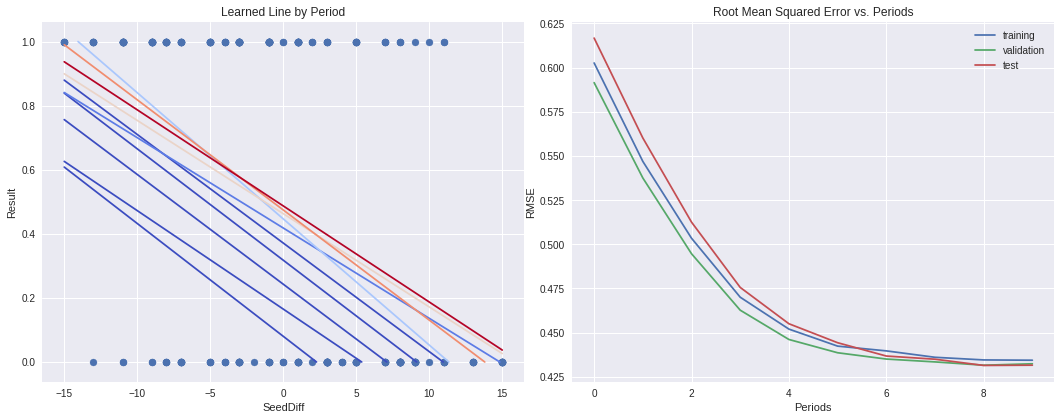

In [15]:
train_linear_model(
    learning_rate=0.0003,
    steps=1000,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets
)

### Train linear classifier

Training neural network model...
RMSE (on training data):
  period 00 : 0.47
  period 01 : 0.45
  period 02 : 0.44
  period 03 : 0.43
  period 04 : 0.43
  period 05 : 0.43
  period 06 : 0.43
  period 07 : 0.43
  period 08 : 0.43
  period 09 : 0.43
Model training finished.
Final RMSE (on training data):   0.43
Final RMSE (on validation data): 0.43
Final RMSE (on test data): 0.43


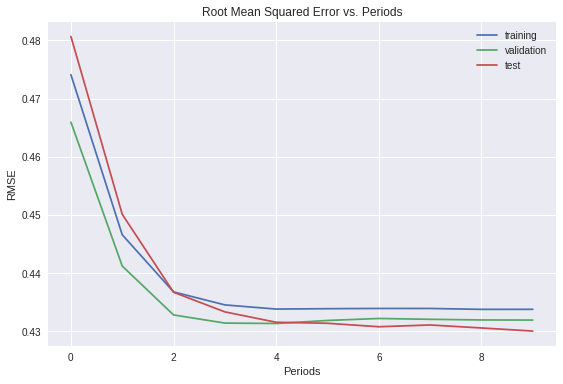

In [23]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    test_examples,
    test_targets):
  """Trains a neural network classification model."""

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["Result"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["Result"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  predict_test_input_fn = lambda: my_input_fn(test_examples, 
                                                    test_targets["Result"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training nn classifier model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  test_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    test_probabilities = linear_classifier.predict(input_fn=predict_test_input_fn)
    test_probabilities = np.array([item['probabilities'] for item in test_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    test_log_loss = metrics.log_loss(test_targets, test_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
    test_log_losses.append(test_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.plot(test_log_losses, label="test")
  plt.legend()

  return linear_classifier

In [0]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.001,
    steps=5000,
    batch_size=90,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

evaluation_metrics = nn_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.3f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.3f" % evaluation_metrics['accuracy'])

In [0]:
validation_probabilities = nn_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

# Neural Network Compact Results Model

### Load data and visualize

In [0]:
# Load datasets

reg_compact = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/RegularSeasonCompactResults.csv", sep=",")
t_compact = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneyCompactResults.csv", sep=",")
t_seeds = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneySeeds.csv", sep=",")

In [26]:
display.display(reg_compact.head())
display.display(t_compact.head())
display.display(t_seeds.head())

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Essential functions

In [0]:
def make_reg_season_data(reg_compact_data):
  # For each season with regular season statistics, aggregate all of the game statistics for the winning and losing team,
  # and their opponents stats for each game played.
  dataframe = reg_compact_data.copy()
  dataframe = dataframe.drop(labels=["NumOT", "DayNum"], axis=1)
  dataframe_w_team = dataframe.groupby(['WTeamID', 'Season']).agg({'WScore': ["mean", "count"]})
  dataframe_l_team = dataframe.groupby(['LTeamID', 'Season']).agg({'LScore': ["mean", "count"]})
  dataframe_w_opp = dataframe.groupby(['LTeamID', 'Season']).agg({'WScore': ["mean", "count"]})
  dataframe_w_opp = dataframe_w_opp.rename(columns={'WScore':'OppWScore'})
  dataframe_l_opp = dataframe.groupby(['WTeamID', 'Season']).agg({'LScore': ["mean", "count"]})
  dataframe_l_opp = dataframe_l_opp.rename(columns={'LScore':'OppLScore'})

  # Rename the index names so that they can be merged
  dataframe_w_team.index.names = ['TeamID', 'Season']
  dataframe_l_team.index.names = ['TeamID', 'Season']
  dataframe_w_opp.index.names = ['TeamID', 'Season']
  dataframe_l_opp.index.names = ['TeamID', 'Season']
  
  # Merge teams
  dataframe_w = dataframe_w_team.join(dataframe_w_opp, how = 'outer')
  dataframe_l = dataframe_l_team.join(dataframe_l_opp, how = 'outer')
  dataframe = dataframe_w.join(dataframe_l, how = 'outer')
  
  # Include calculated win percentage. 'GamesPlayed' will be used to compute the weighted averages of the winning/losing game statistics for each team for each season.
  dataframe['GamesPlayed'] = dataframe['WScore']['count'] + dataframe['LScore']['count']
  dataframe['WinPercent'] = dataframe['WScore']['count']/dataframe['GamesPlayed']
  
  # Game statistics names for the combined list.
  stats = ['Score']
  # Combine winning/losing game stats into season stats for each team.
  for stat in stats:
      dataframe['Team' + stat] = (dataframe['W' + stat]['mean']*dataframe['W' + stat]['count'] + dataframe['L' + stat]['mean']*dataframe['L' + stat]['count'])/dataframe['GamesPlayed']
      dataframe['Opp' + stat] = (dataframe['OppW' + stat]['mean']*dataframe['OppW' + stat]['count'] + dataframe['OppL' + stat]['mean']*dataframe['OppL' + stat]['count'])/dataframe['GamesPlayed']
      del dataframe['W' + stat]
      del dataframe['L' + stat]
      del dataframe['OppW' + stat]
      del dataframe['OppL' + stat]
      
  dataframe['PointDiff'] = dataframe['TeamScore'] - dataframe['OppScore']
  
  return dataframe

In [0]:
def make_tourney_data(t_seeds, t_compact):
  # Clean Data
  local_t_seeds = t_seeds.copy()
  local_t_seeds['Seed'] = local_t_seeds['Seed'].apply(lambda seed: int(seed[1:3]))
  t_wseeds = local_t_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
  t_lseeds = local_t_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})
  t_compact = t_compact.drop(labels=["DayNum", "WScore", "LScore", "WLoc", "NumOT"], axis=1)
  t_compact = t_compact.rename(columns={'WTeam': 'WTeamID', 'LTeam': 'LTeamID'})

  # Merge Seeds with Team ID
  t_dummy = pd.merge(left=t_compact, right=t_wseeds, how='left', on=['Season', 'WTeamID'])
  t_concat = pd.merge(left=t_dummy, right=t_lseeds, on=['Season', 'LTeamID'])
  t_concat['SeedDiff'] = t_concat['WSeed'] - t_concat['LSeed']

  # make DataFrame that summarizes SeedDiff and Result
  t_concat = t_concat.drop(labels=["WSeed", "LSeed"], axis=1)
  t_wins = t_concat.copy()
  t_wins['Result'] = 1

  t_losses = t_concat.copy()
  t_losses['SeedDiff'] = -t_concat['SeedDiff']
  t_losses['Result'] = 0

  # concat seediff with results into DataFrame to use for predictions
  full_results = pd.concat((t_wins, t_losses))
  
  stats = ['GamesPlayed','WinPercent','TeamScore', 'OppScore','PointDiff']
  for stat in stats:
    full_results['W' + stat] = 0
  for stat in stats:
    full_results['L' + stat] = 0
  full_results = full_results.apply(lambda ser: ser.astype('float64'))
  
  full_results = full_results.reset_index(drop=True)
  full_results = full_results.reindex(
      np.random.permutation(full_results.index))
  
  return full_results

In [0]:
def lookup_reg_season(tourney_series):
  '''Used as lambda function to add reg_season results to t_results series'''
  stats = ['GamesPlayed','WinPercent','TeamScore', 'OppScore','PointDiff']
  season = tourney_series['Season']
  wteam = tourney_series['WTeamID']
  lteam = tourney_series['LTeamID']
  w_reg_season_stats = reg_season.xs((wteam, season), level=('TeamID', 'Season'))
  l_reg_season_stats = reg_season.xs((lteam, season), level=('TeamID', 'Season'))
  for stat in stats:
    tourney_series['W' + stat] = w_reg_season_stats[stat]
  for stat in stats:
    tourney_series['L' + stat] = l_reg_season_stats[stat]
  return tourney_series

### Run data through pipeline to make it usable

In [0]:
reg_season = make_reg_season_data(reg_compact)
t_results = make_tourney_data(t_seeds, t_compact)
prediction_results = (t_results.apply(lookup_reg_season, axis=1)).dropna(axis=0, how='any')

In [57]:
display.display(reg_season.head())
display.display(prediction_results.head())

GamesPlayed WinPercent TeamScore OppScore PointDiff
                                                                 
TeamID Season                                                    
1101   2014          21.0        0.1      63.1     78.6     -15.5
       2015          28.0        0.2      61.0     71.9     -10.9
       2016          27.0        0.3      69.9     76.3      -6.4
       2017          25.0        0.4      67.9     72.6      -4.8
1102   1985          24.0        0.2      63.1     68.9      -5.8

,Season,WTeamID,LTeamID,SeedDiff,Result,WGamesPlayed,WWinPercent,WTeamScore,WOppScore,WPointDiff,LGamesPlayed,LWinPercent,LTeamScore,LOppScore,LPointDiff
3277,2003.0,1277.0,1160.0,3.0,0.0,31.0,0.6,67.2,61.0,6.3,31.0,0.6,75.5,70.1,5.5
4186,2017.0,1462.0,1268.0,-5.0,0.0,34.0,0.6,74.6,71.4,3.3,31.0,0.7,73.5,68.5,5.0
781,1997.0,1344.0,1266.0,3.0,1.0,31.0,0.6,74.7,69.2,5.5,30.0,0.7,68.3,57.0,11.3
2758,1995.0,1400.0,1332.0,-5.0,0.0,28.0,0.8,93.9,81.1,12.8,25.0,0.7,84.9,80.0,4.8
2479,1990.0,1462.0,1207.0,-3.0,0.0,29.0,0.9,83.3,72.6,10.7,25.0,0.8,79.8,67.2,12.6


### Partition data into training, validation, and test dataframes

In [0]:
STATS = ['SeedDiff', 'WSeason', 'LSeason', 'WGamesPlayed', 'LGamesPlayed','WWinPercent', 'LWinPercent', 'WTeamScore', 'LTeamScore', 'WOppScore', 'LOppScore', 'WPointDiff', 'LPointDiff']
# STATS = ['SeedDiff', 'WPointDiff', 'LPointDiff', 'WWinPercent', 'LWinPercent', 'WGamesPlayed', 'LGamesPlayed']

In [0]:
# concat seediff with results into DataFrame to use for predictions
prediction_results = prediction_results.reindex(
    np.random.permutation(prediction_results.index))

# Calculate indices for training, validation, testing
num_total_examples = len(prediction_results.index)
num_training_examples = math.floor(num_total_examples*0.7)
num_validation_examples = math.floor(num_total_examples*0.15)
index_validation_examples = num_training_examples + num_validation_examples
num_test_examples = math.floor(num_total_examples*0.15)
index_test_examples = num_training_examples + num_validation_examples + num_test_examples

# Choose the first 65% of examples for training  and normalize.
training_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[0:num_training_examples]))
training_targets = preprocess_targets(prediction_results.iloc[0:num_training_examples])

# Choose 15% after training examples for validation  and normalize
validation_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[num_training_examples:index_validation_examples]))
validation_targets = preprocess_targets(prediction_results.iloc[num_training_examples:index_validation_examples])

# Choose 15% after validation examples for testing  and normalize
test_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[index_validation_examples:index_test_examples]))
test_targets = preprocess_targets(prediction_results.iloc[index_validation_examples:index_test_examples])

In [0]:
# Double-check that we've done the right thing.

print("Training examples summary:")
display.display(training_examples.describe())
display.display(training_examples.isnull().values.any())
print("Validation examples summary:")
display.display(validation_examples.describe())
display.display(validation_examples.isnull().values.any())
print("Test examples summary:")
display.display(test_examples.describe())
display.display(test_examples.isnull().values.any())

print("Training examples head:")
display.display(training_examples.head())
print("Validation examples head:")
display.display(validation_examples.head())
print("Test examples head:")
display.display(test_examples.head())

# print("Training targets summary:") 
# display.display(training_targets.describe())
# display.display(training_targets.isnull().values.any())
# print("Validation targets summary:")
# display.display(validation_targets.describe())
# display.display(validation_targets.isnull().values.any())
# print("Test targets summary:")
# display.display(test_targets.describe())
# display.display(test_targets.isnull().values.any())

### Test out neural network regressor

Training neural network model...
RMSE (on training data):
  period 00 : 0.49
  period 01 : 0.48
  period 02 : 0.46
  period 03 : 0.43
  period 04 : 0.42
  period 05 : 0.41
  period 06 : 0.41
  period 07 : 0.40
  period 08 : 0.40
  period 09 : 0.40
Model training finished.
Final RMSE (on training data):   0.40
Final RMSE (on validation data): 0.40
Final RMSE (on test data): 0.41


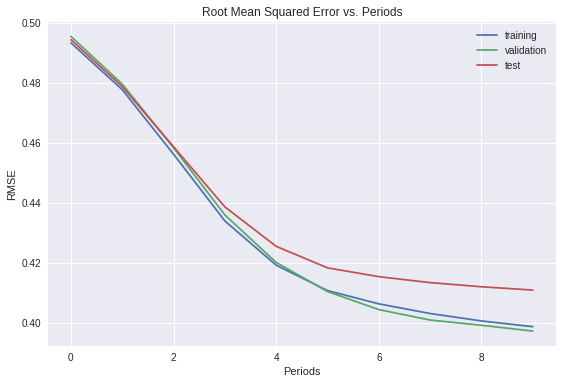

In [90]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001),
    steps=9000,
    batch_size=90,
    hidden_units=[10, 10, 10, 5, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

### Test out neural network classifier

Training nn classifier model...
LogLoss (on training data):
  period 00 : 0.63
  period 01 : 0.56
  period 02 : 0.52
  period 03 : 0.50
  period 04 : 0.48
  period 05 : 0.47
  period 06 : 0.46
  period 07 : 0.46
  period 08 : 0.45
  period 09 : 0.45
Model training finished.
AUC on the validation set: 0.851
Accuracy on the validation set: 0.735


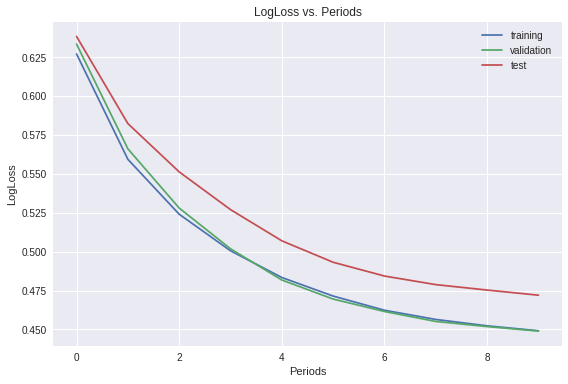

In [93]:
nn_classifier = train_nn_classifier_model(
    learning_rate=0.00015,
    steps=9000,
    batch_size=90,
    hidden_units=[10, 10, 10, 5, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

evaluation_metrics = nn_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.3f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.3f" % evaluation_metrics['accuracy'])

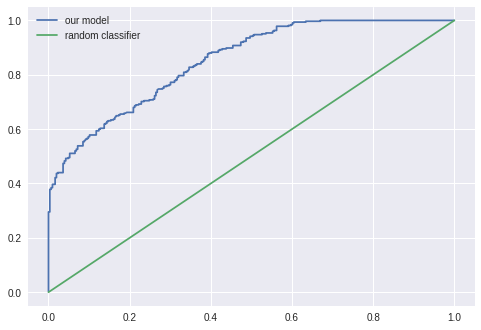

In [94]:
validation_probabilities = nn_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

# Neural Network Detailed Results Model

In [0]:
# Load datasets

# reg_compact = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/RegularSeasonCompactResults.csv", sep=",")
# seasons = pd.read_csv("https://storage.googleapis.com/march_madness_ml_datasets/Seasons.csv", sep=",")
# teams = pd.read_csv("https://storage.googleapis.com/march_madness_ml_datasets/Teams.csv", sep=",")
# t_slots = pd.read_csv("https://storage.googleapis.com/march_madness_ml_datasets/TourneySlots.csv", sep=",")
# t_compact = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneyCompactResults.csv", sep=",")
t_detailed = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneyDetailedResults.csv", sep=",")
reg_detailed = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/RegularSeasonDetailedResults.csv", sep=",")
t_seeds = pd.read_csv("https://storage.googleapis.com/march-madness-ml-2018/NCAATourneySeeds.csv", sep=",")

### Essential Functions

In [0]:
def make_reg_season_data(reg_detailed_data):
  # For each season with regular season statistics, aggregate all of the game statistics for the winning and losing team,
  # and their opponents stats for each game played.
  dataframe = reg_detailed_data.copy()
  dataframe = dataframe.drop(labels=["NumOT", "DayNum", 'WLoc'], axis=1)
  
  dataframe_w_team = dataframe.groupby(['WTeamID', 'Season']).agg({'WScore': ["mean", "count"], 'WFGM': ["mean", "count"], 'WFGA': ["mean", "count"], 'WFGM3': ["mean", "count"], 'WFGA3': ["mean", "count"], 
                                                         'WFTM': ["mean", "count"], 'WFTA': ["mean", "count"], 'WOR': ["mean", "count"], 'WDR': ["mean", "count"], 'WAst': ["mean", "count"],
                                                        'WTO': ["mean", "count"], 'WStl': ["mean", "count"], 'WBlk': ["mean", "count"], 'WPF': ["mean", "count"]})
  dataframe_l_team = dataframe.groupby(['LTeamID', 'Season']).agg({'LScore': ["mean", "count"], 'LFGM': ["mean", "count"], 
                                                        'LFGA': ["mean", "count"], 'LFGM3': ["mean", "count"], 'LFGA3': ["mean", "count"], 
                                                         'LFTM': ["mean", "count"], 'LFTA': ["mean", "count"], 'LOR': ["mean", "count"], 'LDR': ["mean", "count"], 'LAst': ["mean", "count"],
                                                        'LTO': ["mean", "count"], 'LStl': ["mean", "count"], 'LBlk': ["mean", "count"], 'LPF': ["mean", "count"]})
  dataframe_w_opp = dataframe.groupby(['LTeamID', 'Season']).agg({'WScore': ["mean", "count"], 'WFGM': ["mean", "count"], 'WFGA': ["mean", "count"], 'WFGM3': ["mean", "count"], 'WFGA3': ["mean", "count"], 
                                                         'WFTM': ["mean", "count"], 'WFTA': ["mean", "count"], 'WOR': ["mean", "count"], 'WDR': ["mean", "count"], 'WAst': ["mean", "count"],
                                                        'WTO': ["mean", "count"], 'WStl': ["mean", "count"], 'WBlk': ["mean", "count"], 'WPF': ["mean", "count"]})
  dataframe_w_opp = dataframe_w_opp.rename(columns={'WScore':'OppWScore', 'WFGM':'OppWFGM', 'WFGA':'OppWFGA', 'WFGM3':'OppWFGM3', 'WFGA3':'OppWFGA3', 'WFTM':'OppWFTM',
                                                        'WFTA':'OppWFTA', 'WOR':'OppWOR', 'WDR':'OppWDR', 'WAst':'OppWAst', 'WTO':'OppWTO', 'WStl':'OppWStl', 'WBlk':'OppWBlk',
                                                        'WPF':'OppWPF'})
  dataframe_l_opp = dataframe.groupby(['WTeamID', 'Season']).agg({'LScore': ["mean", "count"], 'LFGM': ["mean", "count"], 
                                                        'LFGA': ["mean", "count"], 'LFGM3': ["mean", "count"], 'LFGA3': ["mean", "count"], 
                                                         'LFTM': ["mean", "count"], 'LFTA': ["mean", "count"], 'LOR': ["mean", "count"], 'LDR': ["mean", "count"], 'LAst': ["mean", "count"],
                                                        'LTO': ["mean", "count"], 'LStl': ["mean", "count"], 'LBlk': ["mean", "count"], 'LPF': ["mean", "count"]})
  dataframe_l_opp = dataframe_l_opp.rename(columns={'LScore':'OppLScore', 'LFGM':'OppLFGM', 'LFGA':'OppLFGA', 'LFGM3':'OppLFGM3', 'LFGA3':'OppLFGA3', 'LFTM':'OppLFTM',
                                                        'LFTA':'OppLFTA', 'LOR':'OppLOR', 'LDR':'OppLDR', 'LAst':'OppLAst', 'LTO':'OppLTO', 'LStl':'OppLStl', 'LBlk':'OppLBlk',
                                                        'LPF':'OppLPF'})

  # Rename the index names so that they can be merged
  dataframe_w_team.index.names = ['TeamID', 'Season']
  dataframe_l_team.index.names = ['TeamID', 'Season']
  dataframe_w_opp.index.names = ['TeamID', 'Season']
  dataframe_l_opp.index.names = ['TeamID', 'Season']
  
  # Merge teams
  dataframe_w = dataframe_w_team.join(dataframe_w_opp, how = 'outer')
  dataframe_l = dataframe_l_team.join(dataframe_l_opp, how = 'outer')
  dataframe = dataframe_w.join(dataframe_l, how = 'outer')
  
  # Include calculated win percentage. 'GamesPlayed' will be used to compute the weighted averages of the winning/losing game statistics for each team for each season.
  dataframe['GamesPlayed'] = dataframe['WScore']['count'] + dataframe['LScore']['count']
  dataframe['WinPercent'] = dataframe['WScore']['count']/dataframe['GamesPlayed']
  
  # Game statistics names for the combined list.
  stats = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']
  # Combine winning/losing game stats into season stats for each team.
  for stat in stats:
      dataframe['Team' + stat] = (dataframe['W' + stat]['mean']*dataframe['W' + stat]['count'] + dataframe['L' + stat]['mean']*dataframe['L' + stat]['count'])/dataframe['GamesPlayed']
      dataframe['Opp' + stat] = (dataframe['OppW' + stat]['mean']*dataframe['OppW' + stat]['count'] + dataframe['OppL' + stat]['mean']*dataframe['OppL' + stat]['count'])/dataframe['GamesPlayed']
      del dataframe['W' + stat]
      del dataframe['L' + stat]
      del dataframe['OppW' + stat]
      del dataframe['OppL' + stat]
      
  dataframe['PointDiff'] = dataframe['TeamScore'] - dataframe['OppScore']
  
  # Make percentages for TEAM fg, ft, to/ast, stl/blk
  dataframe['TeamFG'] = dataframe['TeamFGM']/dataframe['TeamFGA']
  del dataframe['TeamFGM']
  del dataframe['TeamFGA']
  dataframe['TeamFG3'] = dataframe['TeamFGM3']/dataframe['TeamFGA3']
  del dataframe['TeamFGM3']
  del dataframe['TeamFGA3']
  dataframe['TeamFT'] = dataframe['TeamFTM']/dataframe['TeamFTA']
  del dataframe['TeamFTM']
  del dataframe['TeamFTA']
  dataframe['TeamAst_TO_Ratio'] = dataframe['TeamAst']/dataframe['TeamTO']
  del dataframe['TeamAst']
  del dataframe['TeamTO']
  
  # Make percentages for OPP fg, ft, to/ast, stl/blk
  dataframe['OppFG'] = dataframe['OppFGM']/dataframe['OppFGA']
  del dataframe['OppFGM']
  del dataframe['OppFGA']
  dataframe['OppFG3'] = dataframe['OppFGM3']/dataframe['OppFGA3']
  del dataframe['OppFGM3']
  del dataframe['OppFGA3']
  dataframe['OppFT'] = dataframe['OppFTM']/dataframe['OppFTA']
  del dataframe['OppFTM']
  del dataframe['OppFTA']
  dataframe['OppAst_TO_Ratio'] = dataframe['OppAst']/dataframe['OppTO']
  del dataframe['OppAst']
  del dataframe['OppTO']
      
      
  return dataframe

In [0]:
def make_tourney_data(t_seeds, t_compact):
  # Clean Data
  local_t_seeds = t_seeds.copy()
  local_t_seeds['Seed'] = local_t_seeds['Seed'].apply(lambda seed: int(seed[1:3]))
  t_wseeds = local_t_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
  t_lseeds = local_t_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})
  t_compact = t_compact.drop(labels=["DayNum", "WScore", "LScore", "WLoc", "NumOT"], axis=1)
  t_compact = t_compact.rename(columns={'WTeam': 'WTeamID', 'LTeam': 'LTeamID'})

  # Merge Seeds with Team ID
  t_dummy = pd.merge(left=t_compact, right=t_wseeds, how='left', on=['Season', 'WTeamID'])
  t_concat = pd.merge(left=t_dummy, right=t_lseeds, on=['Season', 'LTeamID'])
  t_concat['SeedDiff'] = t_concat['WSeed'] - t_concat['LSeed']

  # make DataFrame that summarizes SeedDiff and Result
  t_concat = t_concat.drop(labels=["WSeed", "LSeed"], axis=1)
  t_wins = t_concat.copy()
  t_wins['Result'] = 1
#   t_wins = t_wins.drop(labels=["LTeamID"], axis=1)
#   t_wins = t_wins.rename(columns={'WTeamID':'TeamID'})

  t_losses = t_concat.copy()
  t_losses['SeedDiff'] = -t_concat['SeedDiff']
  t_losses['Result'] = 0
#   t_losses = t_losses.drop(labels=["WTeamID"], axis=1)
#   t_losses = t_losses.rename(columns={'LTeamID':'TeamID'})

  # concat seediff with results into DataFrame to use for predictions
  full_results = pd.concat((t_wins, t_losses))
  
  stats = ['GamesPlayed','WinPercent','PointDiff',
           'TeamScore', 'TeamFG','TeamFG3','TeamFT', 'TeamOR', 'TeamDR', 'TeamAst_TO_Ratio', 'TeamStl', 'TeamBlk', 'TeamPF',
           'OppScore', 'OppFG','OppFG3','OppFT', 'OppOR', 'OppDR', 'OppAst_TO_Ratio', 'OppStl', 'OppBlk', 'OppPF'
          ]
  for stat in stats:
    full_results['W' + stat] = 0
  for stat in stats:
    full_results['L' + stat] = 0
  full_results = full_results.apply(lambda ser: ser.astype('float64'))
  
  full_results = full_results.reset_index(drop=True)
  full_results = full_results.reindex(
      np.random.permutation(full_results.index))
  
  return full_results

In [0]:
def lookup_reg_season(tourney_series):
  stats = ['GamesPlayed','WinPercent','PointDiff',
           'TeamScore', 'TeamFG','TeamFG3','TeamFT', 'TeamOR', 'TeamDR', 'TeamAst_TO_Ratio', 'TeamStl', 'TeamBlk', 'TeamPF',
           'OppScore', 'OppFG','OppFG3','OppFT', 'OppOR', 'OppDR', 'OppAst_TO_Ratio', 'OppStl', 'OppBlk', 'OppPF'
          ]
  season = tourney_series['Season']
  if season >= 2003:
    wteam = tourney_series['WTeamID']
    lteam = tourney_series['LTeamID']
    w_reg_season_stats = reg_season.xs((wteam, season), level=('TeamID', 'Season'))
    l_reg_season_stats = reg_season.xs((lteam, season), level=('TeamID', 'Season'))
    for stat in stats:
      tourney_series['W' + stat] = w_reg_season_stats[stat]
    for stat in stats:
      tourney_series['L' + stat] = l_reg_season_stats[stat]
    return tourney_series

### Run data through pipeline to make useable

In [0]:
reg_season = make_reg_season_data(reg_detailed)
t_results = make_tourney_data(t_seeds, t_compact)
display.display(reg_season.head())
display.display(t_results.head())

In [0]:
prediction_results = t_results.apply(lookup_reg_season, axis=1)
prediction_results = prediction_results.dropna(axis=0, how='any')

In [124]:
display.display(reg_season.head())
display.display(t_results.head())
display.display(prediction_results.head())

GamesPlayed WinPercent TeamScore OppScore TeamOR OppOR TeamDR  \
                                                                              
TeamID Season                                                                 
1101   2014          21.0        0.1      63.1     78.6    8.0  10.4   20.3   
       2015          28.0        0.2      61.0     71.9    8.3  10.0   19.6   
       2016          27.0        0.3      69.9     76.3    8.2   8.6   22.5   
       2017          25.0        0.4      67.9     72.6    7.6  10.6   22.9   
1102   2003          28.0        0.4      57.2     57.0    4.2   9.6   16.8   

              OppDR TeamStl OppStl       ...       OppPF PointDiff TeamFG  \
                                         ...                                
TeamID Season                            ...                                
1101   2014    24.1     5.8    7.0       ...        18.7     -15.5    0.4   
       2015    25.9     5.9    5.9       ...        16.5     -10.9    0.4   
       2016    25.2     6.7    5.1       ...        19.7      -6.4    0.4   
       2017    25.0     7.0    6.0       ...        17.2      -4.8    0.5   
1102   2003    20.1     6.0    5.4       ...        18.4       0.2    0.5   

              TeamFG3 TeamFT TeamAst_TO_Ratio OppFG OppFG3 OppFT  \
                                                                   
TeamID Season                                                      
1101   2014       0.4    0.7              0.7   0.5    0.4   0.7   
       2015       0.4    0.7              0.9   0.5    0.4   0.7   
       2016       0.4    0.7              1.0   0.5    0.4   0.7   
       2017       0.4    0.6              0.9   0.5    0.4   0.7   
1102   2003       0.4    0.7              1.1   0.5    0.4   0.7   

              OppAst_TO_Ratio  
                               
TeamID Season                  
1101   2014               1.3  
       2015               1.0  
       2016               1.0  
       2017               0.9  
1102   2003               0.7  

[5 rows x 23 columns]

,Season,WTeamID,LTeamID,SeedDiff,Result,WGamesPlayed,WWinPercent,WPointDiff,WTeamScore,WTeamFG,...,LOppScore,LOppFG,LOppFG3,LOppFT,LOppOR,LOppDR,LOppAst_TO_Ratio,LOppStl,LOppBlk,LOppPF
2495,1991.0,1112.0,1384.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1272,2005.0,1328.0,1310.0,-11.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3334,2004.0,1130.0,1428.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3863,2012.0,1325.0,1276.0,-9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1637,2010.0,1124.0,1388.0,-7.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1272    [6.91355077988007e-310, 6.91355077988007e-310,...
3334    [6.91355077988007e-310, 6.91355077988007e-310,...
3863    [6.91355077988007e-310, 6.91355077988007e-310,...
1637    [6.91355077988007e-310, 6.91355077988007e-310,...
3613    [6.91355077988007e-310, 6.91355077988007e-310,...
dtype: object

### Partition data into training, validation, and test dataframes

In [0]:
STATS = ['SeedDiff', 'WGamesPlayed', 'LGamesPlayed', 'WWinPercent', 'LWinPercent', 'WTeamScore', 'LTeamScore', 
         'WOppScore', 'LOppScore', 'WPointDiff', 'LPointDiff', 'WFG', 'LFG', 'WFG3', 'LFG3', 'WFT', 'LFT', 
         'WOR', 'LOR', 'WDR', 'LDR', 'WAst_TO_Ratio', 'LAst_TO_Ratio', 'WStl', 'LStl', 'WBlk', 'LBlk', 'WPF', 'LPF']
# STATS = ['SeedDiff', 'PointDiff', 'WinPercent']

In [0]:
# concat seediff with results into DataFrame to use for predictions
prediction_results = prediction_results.reindex(
    np.random.permutation(prediction_results.index))

# Calculate indices for training, validation, testing
num_total_examples = len(prediction_results.index)
num_training_examples = math.floor(num_total_examples*0.7)
num_validation_examples = math.floor(num_total_examples*0.15)
index_validation_examples = num_training_examples + num_validation_examples
num_test_examples = math.floor(num_total_examples*0.15)
index_test_examples = num_training_examples + num_validation_examples + num_test_examples

# Choose the first 65% of examples for training  and normalize.
training_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[0:num_training_examples]))
training_targets = preprocess_targets(prediction_results.iloc[0:num_training_examples])

# Choose 15% after training examples for validation  and normalize
validation_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[num_training_examples:index_validation_examples]))
validation_targets = preprocess_targets(prediction_results.iloc[num_training_examples:index_validation_examples])

# Choose 15% after validation examples for testing  and normalize
test_examples = normalize_linear_scale(preprocess_features(prediction_results.iloc[index_validation_examples:index_test_examples]))
test_targets = preprocess_targets(prediction_results.iloc[index_validation_examples:index_test_examples])

In [0]:
_ = training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [0]:
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
display.display(training_examples.isnull().values.any())
print("Validation examples summary:")
display.display(validation_examples.describe())
display.display(validation_examples.isnull().values.any())
print("Test examples summary:")
display.display(test_examples.describe())
display.display(test_examples.isnull().values.any())

# print("Training targets summary:") 
display.display(training_targets.describe())
display.display(training_targets.isnull().values.any())
print("Validation targets summary:")
display.display(validation_targets.describe())
display.display(validation_targets.isnull().values.any())
print("Test targets summary:")
display.display(test_targets.describe())
display.display(test_targets.isnull().values.any())

### Test out neural network regressor

Training neural network model...
RMSE (on training data):
  period 00 : 0.49
  period 01 : 0.46
  period 02 : 0.45
  period 03 : 0.44
  period 04 : 0.44
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.44
Model training finished.
Final RMSE (on training data):   0.44
Final RMSE (on validation data): 0.44
Final RMSE (on test data): 0.43


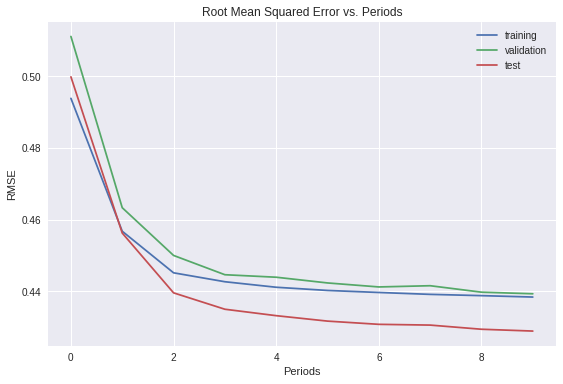

In [303]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0005),
    steps=7000,
    batch_size=60,
    hidden_units=[10, 10, 10, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

Training neural network model...
RMSE (on training data):
  period 00 : 0.50
  period 01 : 0.45
  period 02 : 0.45
  period 03 : 0.44
  period 04 : 0.44
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.44
Model training finished.
Final RMSE (on training data):   0.44
Final RMSE (on validation data): 0.44
Final RMSE (on test data): 0.43


ValueError: ignored

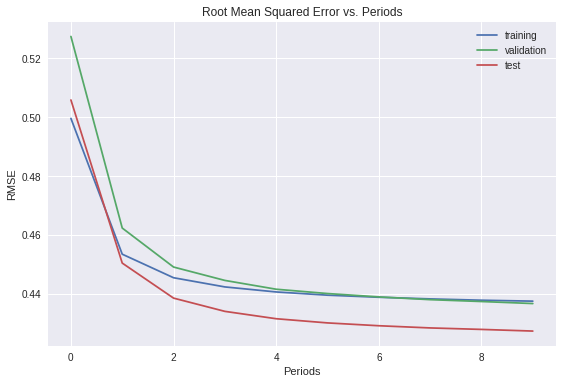

In [309]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.0006),
    steps=10000,
    batch_size=60,
    hidden_units=[10, 10, 10, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

Training neural network model...
RMSE (on training data):
  period 00 : 0.44
  period 01 : 0.44
  period 02 : 0.43
  period 03 : 0.43
  period 04 : 0.43
  period 05 : 0.43
  period 06 : 0.43
  period 07 : 0.43
  period 08 : 0.43
  period 09 : 0.43
Model training finished.
Final RMSE (on training data):   0.43
Final RMSE (on validation data): 0.43
Final RMSE (on test data): 0.42


ValueError: ignored

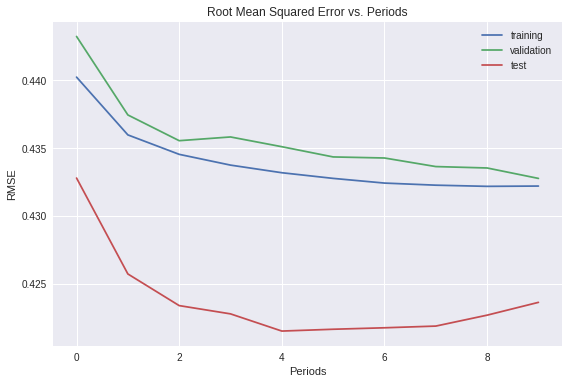

In [310]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),
    steps=8000,
    batch_size=60,
    hidden_units=[10, 10, 10, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

### Test out neural network classifier

In [0]:
nn_classifier = train_nn_classifier_model(
    learning_rate=0.00025,
    steps=6000,
    batch_size=90,
    hidden_units=[10, 10, 5, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    test_examples=test_examples,
    test_targets=test_targets)

evaluation_metrics = nn_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

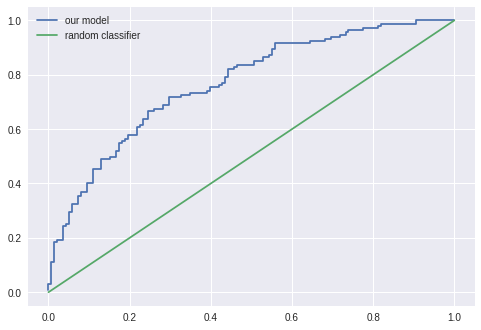

In [77]:
validation_probabilities = nn_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)